# Risk Overlay & Stress Testing

**Boyang Gong**

**Last Updated: Novemeber 4, 2025**

- Goal: Build additional risk checks on portfolio outputs. Implement a simple risk manager that evaluates a portfolio's daily returns under market shock scenarios and checks them against a loss limit before execution.

- Tasks:
  - Create `StressTester.ipynb`.
    - `returns.csv`
    - Date,PortfolioReturn
    - 2025-01-29,0.002
    - 2025-01-30,-0.001
    - 2025-01-31,0.004
  - Simulate market shocks (±5 %, ±10 %) on portfolio returns.
  - Compute worst-case loss (VaR 95 %, CVaR 99 %).
  - Flag if any scenario breaches loss threshold.
  - Output:
    - scenario,VaR_95,CVaR_99,worst_loss,breach_flag
    - -5%,0.025,0.040,0.042,False
    - -10%,0.050,0.075,0.079,True
- Deliverables: A risk-limit system that approves or rejects portfolios before execution.



## Setup




In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Set target folder in Drive
import os
target_dir = "/content/drive/MyDrive/DSGT Project - RoboInvesting/StressTester"
os.makedirs(target_dir, exist_ok=True)  # creates it if it doesn't exist

In [3]:
# Import
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import math
from pathlib import Path
plt.rcParams['figure.figsize'] = (10, 5)


## Configuration

- Load returns from `returns.csv`
- If the `returns.csv` is missing and `USE_YFINANCE=True`, it pulls AAPL daily prices via yfinance, computes daily returns, and writes a compliant `returns.csv` for a sample data.
- Stress scenarios: ±5%, ±10% multiplicative shocks.
- Risk metrics per scenario:
  - VaR 95% (magnitude)
  - CVaR 99% (magnitude)
  - Worst single-day loss (magnitude)
- Breach flag: True if any metric exceeds `LOSS_LIMIT`.
- Decision: APPROVE or REJECT based on breaches across scenarios.

> **Note:** VaR/CVaR are computed on the shocked daily return distribution.
  Magnitudes are reported as positive numbers (e.g., 0.075 = 7.5% loss).

In [4]:
USE_YFINANCE = True          # True: If returns.csv missing, pull AAPL to create one
                             # False: If returns.csv missing, raise FileNotFoundError
TICKER = 'AAPL'              # Used only if we need to generate returns.csv
START_DATE = '2022-01-01'    # AAPL start date if generating
END_DATE = None              # None = today

SCENARIOS = [-0.10, -0.05, 0.05, 0.10]  # multiplicative shocks: -10%, -5%, +5%, +10%
VAR_LEVEL = 0.95
CVAR_LEVEL = 0.99
LOSS_LIMIT = 0.075           # 7.5% max tolerable loss magnitude
MIN_OBS_REQUIRED = 200       # Require at least N daily returns for stable stats

INPUT_CSV = os.path.join(target_dir, "returns.csv")
OUTPUT_CSV = os.path.join(target_dir, "scenario_results.csv")

## Load Returns

In [5]:
def load_or_create_returns_csv(path=INPUT_CSV):
    p = Path(path)
    # If returns.csv exists, just read from this csv
    if p.exists():
        df = pd.read_csv(p, parse_dates=['Date'])
        df = df.sort_values('Date')
        return df

    # If returns.csv not exists, but USE_YFINANCE=False, then raise an error.
    if not USE_YFINANCE:
        raise FileNotFoundError(
            f"{path} not found and USE_YFINANCE=False. Please provide a CSV with Date,PortfolioReturn."
        )

    # Generate returns.csv from yfinance
    print('returns.csv not found — pulling data from yfinance to create one...')
    # Resolve end date
    if END_DATE is None:
        end_dt = pd.Timestamp.today().normalize()
    else:
        end_dt = pd.to_datetime(END_DATE)
    # yfinance returns a DataFrame
    data = yf.download(TICKER, start=START_DATE, end=end_dt, progress=False)
    if 'Adj Close' in data.columns:
        px = data['Adj Close'].dropna()
    else:
        px = data['Close'].dropna()

    df = px.pct_change().dropna().reset_index()
    df.columns = ['Date', 'PortfolioReturn']
    df.to_csv(p, index=False)
    print(f'Wrote {p} with {len(df)} rows from {TICKER}.')
    return df

df_returns = load_or_create_returns_csv()
df_returns.head()

,Date,PortfolioReturn
0,2022-01-04,-0.012692
1,2022-01-05,-0.026600
2,2022-01-06,-0.016694
3,2022-01-07,0.000989
4,2022-01-10,0.000116


In [6]:
# Convert the df into a clean series indexed by the date
# Ensure enough observations
series = pd.Series(df_returns['PortfolioReturn'].values, index=pd.to_datetime(df_returns['Date']))
series = series.sort_index().dropna()
print(f'Loaded {len(series)} daily returns. Window: {series.index.min().date()} --> {series.index.max().date()}')
if len(series) < MIN_OBS_REQUIRED:
    raise ValueError(
        f'Only {len(series)} rows found; need at least {MIN_OBS_REQUIRED}. Supply a longer CSV or change START_DATE.'
    )

Loaded 962 daily returns. Window: 2022-01-04 --> 2025-11-03


## Stress Testing Algorithm


We apply **multiplicative shocks** to returns:
$(1+r)\times(1+\text{shock}) - 1$.

<!-- So a −10% shock scales every daily move by 0.9. -->

In [7]:
def apply_shock(returns: pd.Series, shock: float) -> pd.Series:
    """Apply a multiplicative shock to returns: r_s = (1+r)*(1+shock) - 1."""
    return (1.0 + returns) * (1.0 + shock) - 1.0

def var_magnitude(returns: pd.Series, level: float) -> float:
    """Return VaR magnitude at 'level'. Non-negative value.
    We compute the lower tail quantile (1 - level) and return its absolute loss size.
    """
    q = returns.quantile(1.0 - level)
    return max(0.0, float(-q))

def cvar_magnitude(returns: pd.Series, level: float) -> float:
    """Return CVaR magnitude at 'level'. Non-negative value.
    Average of returns in the worst (1-level) tail.
    """
    cutoff = returns.quantile(1.0 - level)
    tail = returns[returns <= cutoff]
    if len(tail) == 0:
        return 0.0
    es = tail.mean()
    return max(0.0, float(-es))

def worst_loss_magnitude(returns: pd.Series) -> float:
    """Worst single-day loss magnitude. Non-negative value."""
    mn = returns.min()
    return max(0.0, float(-mn))

def run_scenarios(returns: pd.Series, scenarios, loss_limit: float,
                  var_level=0.95, cvar_level=0.99) -> pd.DataFrame:
    # Default VaR level = 0.95, CVaR level = 0.99
    rows = []
    for s in scenarios:
        shocked = apply_shock(returns, s)
        var95 = var_magnitude(shocked, var_level)
        cvar99 = cvar_magnitude(shocked, cvar_level)
        worst = worst_loss_magnitude(shocked)
        breach = (var95 > loss_limit) or (cvar99 > loss_limit) or (worst > loss_limit)
        label = f"{int(s*100)}%" if abs(s*100 - round(s*100)) < 1e-9 else f"{s*100:.1f}%"
        rows.append({
            'scenario': label,
            'VaR_95': round(var95, 6),
            'CVaR_99': round(cvar99, 6),
            'worst_loss': round(worst, 6),
            'breach_flag': bool(breach)
        })
    return pd.DataFrame(rows).set_index('scenario')

## Run Stree Testing && Evaluate Risk Limits

In [8]:
results = run_scenarios(series, SCENARIOS, LOSS_LIMIT, VAR_LEVEL, CVAR_LEVEL)
display(results)
results.to_csv(OUTPUT_CSV)
print(f'Saved scenario table to {OUTPUT_CSV}')

decision = 'REJECTED' if results['breach_flag'].any() else 'APPROVED'
print('\n=== RISK DECISION ===')
print(f'Portfolio is {decision} under LOSS_LIMIT={LOSS_LIMIT:.3%}')

,VaR_95,CVaR_99,worst_loss,breach_flag
scenario,,,,
-10%,0.126268,0.152523,0.183211,True
-5%,0.077728,0.105440,0.137833,True
5%,0.000000,0.011276,0.047079,False
10%,0.000000,0.000000,0.001702,False


Saved scenario table to /content/drive/MyDrive/DSGT Project - RoboInvesting/StressTester/scenario_results.csv

=== RISK DECISION ===
Portfolio is REJECTED under LOSS_LIMIT=7.500%


## Interpretation:
- **VaR 95%**: loss magnitude not exceeded with 95% confidence
- **CVaR 99%**: average loss in the worst 1% of shocked days
- **worst_loss**: the largest single-day loss observed under the scenario.

If any metric exceeds `LOSS_LIMIT`, the scenario **breaches** and the portfolio is **REJECTED**.
Otherwise, it is **APPROVED**.


## Validation

In [9]:
returns = series
scenarios = SCENARIOS
loss_limit = LOSS_LIMIT
var_level = VAR_LEVEL
cvar_level = CVAR_LEVEL

for s in scenarios:
    shocked = apply_shock(returns, s)
    print(shocked.describe())


count    962.000000
mean      -0.099467
std        0.016431
min       -0.183211
25%       -0.107491
50%       -0.099083
75%       -0.091343
max        0.037960
dtype: float64
count    962.000000
mean      -0.049437
std        0.017344
min       -0.137833
25%       -0.057907
50%       -0.049032
75%       -0.040862
max        0.095624
dtype: float64
count    962.000000
mean       0.050622
std        0.019170
min       -0.047079
25%        0.041260
50%        0.051070
75%        0.060100
max        0.210953
dtype: float64
count    962.000000
mean       0.100652
std        0.020083
min       -0.001702
25%        0.090844
50%        0.101121
75%        0.110580
max        0.268617
dtype: float64


If for +5% get q05 ≥ 0, VaR₉₅=0 makes sense.

If for +10%, get p(neg) < 1% and q01 ≥ 0, CVaR₉₉=0 also makes sense.

In [10]:
for s in SCENARIOS:
    r = ((1+series)*(1+s) - 1).values
    p_neg = (r < 0).mean()
    q05 = np.quantile(r, 0.05)
    q01 = np.quantile(r, 0.01)
    print(f"s={s:+.0%}  p(neg)={p_neg:.3%}  q05={q05:.5f}  q01={q01:.5f}")

s=-10%  p(neg)=99.896%  q05=-0.12627  q01=-0.14327
s=-5%  p(neg)=99.272%  q05=-0.07773  q01=-0.09567
s=+5%  p(neg)=1.143%  q05=0.01935  q01=-0.00048
s=+10%  p(neg)=0.104%  q05=0.06789  q01=0.04711


## Visualizations: shocked vs. baseline

In [11]:
do_plot = True

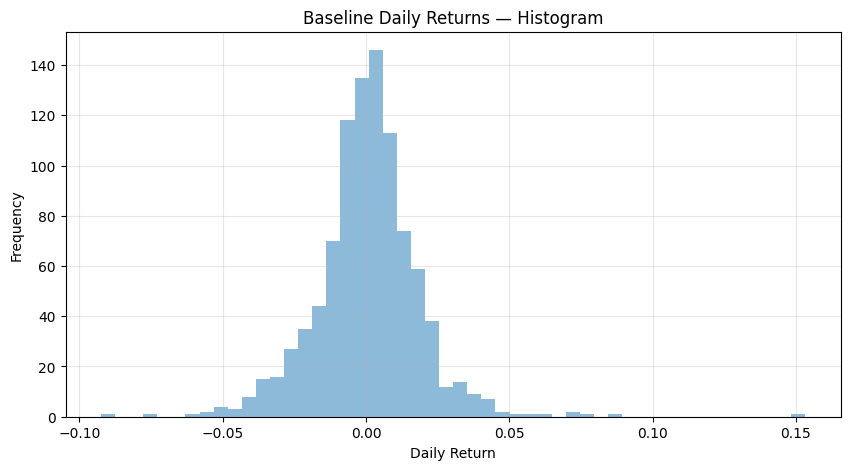

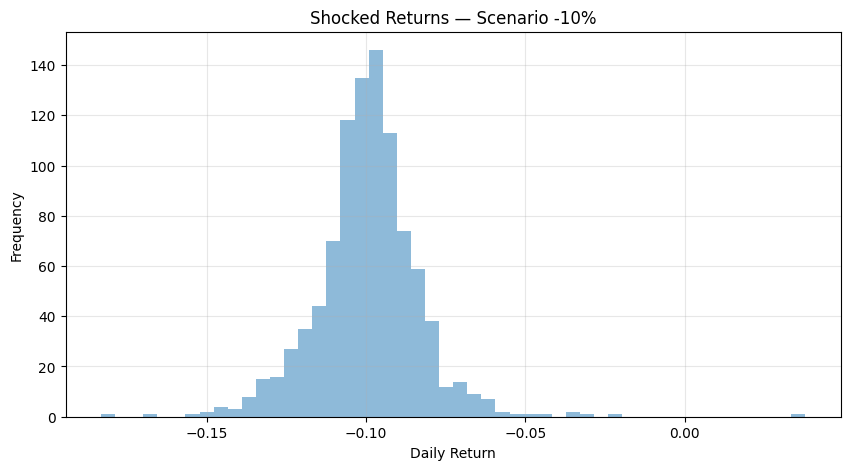

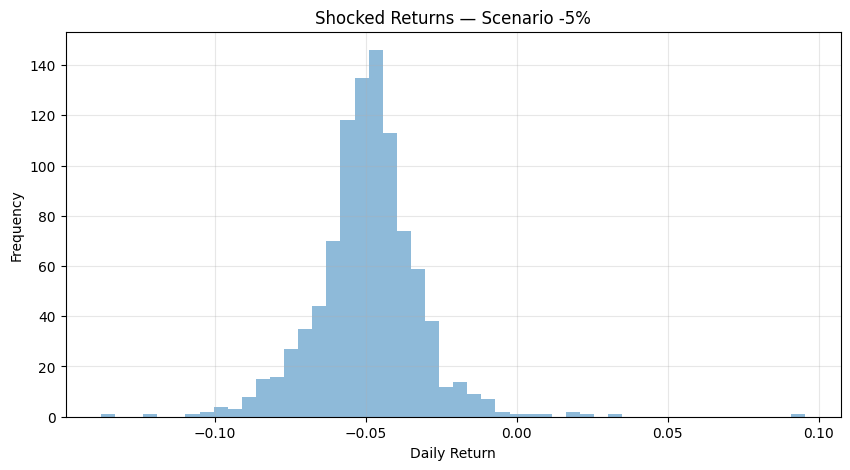

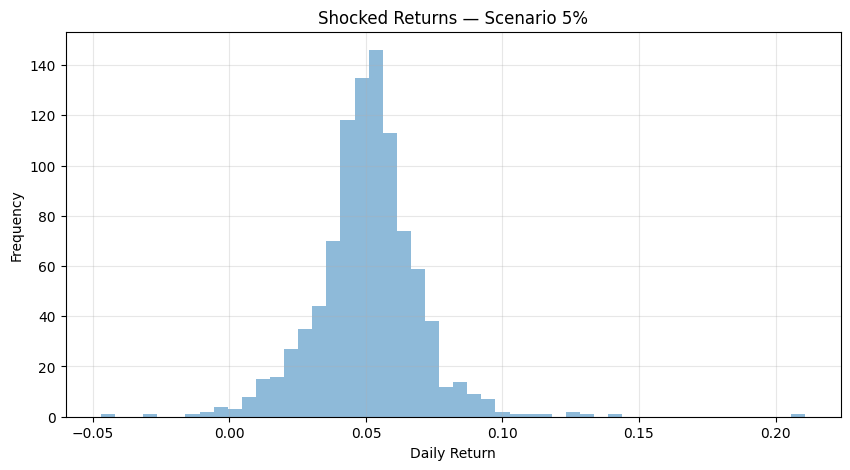

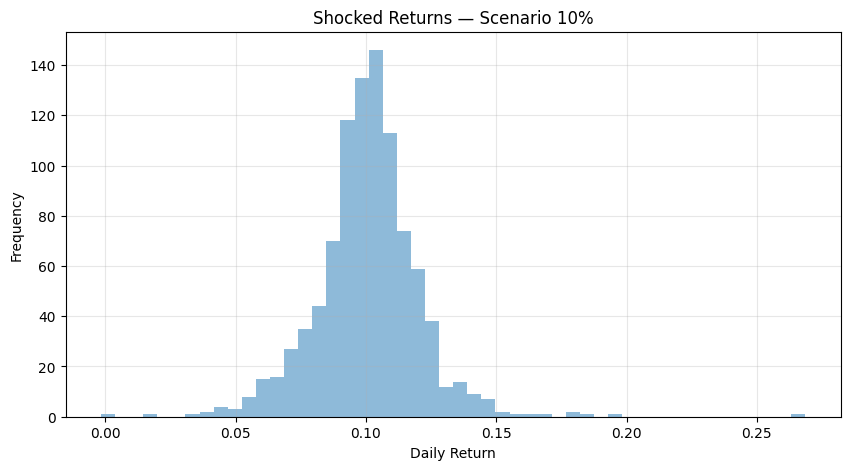

In [12]:
if do_plot:
    fig, ax = plt.subplots(figsize=(10,5))
    ax.hist(series.values, bins=50, alpha=0.5)
    ax.set_title('Baseline Daily Returns — Histogram')
    ax.set_xlabel('Daily Return')
    ax.set_ylabel('Frequency')
    ax.grid(True, alpha=0.3)
    plt.show()

    for s in SCENARIOS:
        shocked = (1+series)*(1+s) - 1
        fig, ax = plt.subplots(figsize=(10,5))
        ax.hist(shocked.values, bins=50, alpha=0.5)
        ax.set_title(f'Shocked Returns — Scenario {int(s*100)}%')
        ax.set_xlabel('Daily Return')
        ax.set_ylabel('Frequency')
        ax.grid(True, alpha=0.3)
        plt.show()


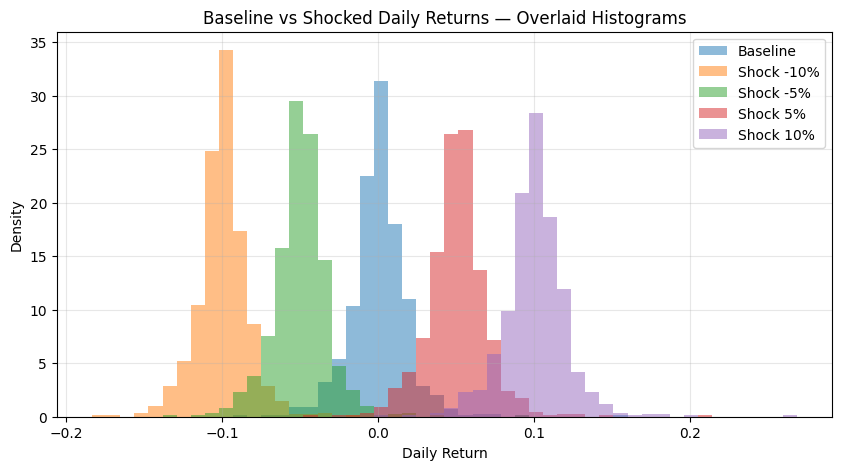

In [13]:
fig, ax = plt.subplots(figsize=(10,5))
bins = 50
xmin = min(series.min(), *((((1+series)*(1+s)-1).min() for s in SCENARIOS)))
xmax = max(series.max(), *((((1+series)*(1+s)-1).max() for s in SCENARIOS)))

ax.hist(series.values, bins=bins, range=(xmin, xmax), alpha=0.5, density=True, label='Baseline')

for s in SCENARIOS:
    shocked = (1+series)*(1+s) - 1
    ax.hist(shocked.values, bins=bins, range=(xmin, xmax), alpha=0.5, density=True,
            label=f'Shock {int(s*100)}%')

ax.set_title('Baseline vs Shocked Daily Returns — Overlaid Histograms')
ax.set_xlabel('Daily Return')
ax.set_ylabel('Density')
ax.grid(True, alpha=0.3)
ax.legend()
plt.show()


<!-- ## Next Steps:

- Add **nonlinear shocks** (e.g., volatility spikes) or regime-dependent scaling.
- Integrate **transaction costs/slippage** into P&L before stress testing.
- Extend to **multi-day horizon VaR** (e.g., 5-day) with appropriate scaling or bootstrapping.
- Enforce **per-scenario** limits (e.g., different limits for VaR vs worst-loss).
- Embed this into **Execution gate** so only APPROVED portfolios proceed. -->